In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import pandas as pd
import distrax
import optax
import blackjax
import chex

import abc
from typing import Optional, Callable, Union, Tuple, Dict, Any, Sequence, List
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from IPython.display import HTML

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [6.0, 4.0]

jax.config.update("jax_platform_name", "cpu")

key = jax.random.PRNGKey(12391)

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



W0000 00:00:1734961061.075531 25523616 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1734961061.085870 25523616 service.cc:145] XLA service 0x1634b4bb0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734961061.085879 25523616 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1734961061.087854 25523616 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1734961061.087875 25523616 mps_client.cc:384] XLA backend will use up to 22906109952 bytes on device 0 for SimpleAllocator.


### Deps


In [2]:
def plot_contours_2D(
    log_prob_func, ax: Optional[plt.Axes] = None, bound: float = 3, levels: int = 20
):
    """Plot the contours of a 2D log prob function."""
    if ax is None:
        fig, ax = plt.subplots(1)
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    ax.contour(x1, x2, z, levels=levels)

def plot_contours_2D_with_time(
    log_prob_func: Callable[[np.ndarray, float], np.ndarray],
    t: float,
    ax: Optional[plt.Axes] = None,
    bound: float = 3,
    levels: int = 20
):
    """Plot the contours of a 2D log prob function at time t."""
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6,6))
    ax.clear()  # Clear previous contours
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points, t)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    contour = ax.contourf(x1, x2, z, levels=levels, cmap='viridis')
    ax.set_title(f"Time t = {t:.2f}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    return contour


def plot_marginal_pair(
    samples: chex.Array,
    ax: Optional[plt.Axes] = None,
    marginal_dims: Tuple[int, int] = (0, 1),
    bounds: Tuple[float, float] = (-5, 5),
    alpha: float = 0.5,
):
    """Plot samples from marginal of distribution for a given pair of dimensions."""
    if not ax:
        fig, ax = plt.subplots(1)
    samples = jnp.clip(samples, bounds[0], bounds[1])
    ax.plot(
        samples[:, marginal_dims[0]], samples[:, marginal_dims[1]], "o", alpha=alpha
    )


def plot_history(history):
    """Agnostic history plotter for quickly plotting a dictionary of logging info."""
    figure, axs = plt.subplots(len(history), 1, figsize=(7, 3 * len(history.keys())))
    if len(history.keys()) == 1:
        axs = [axs]  # make iterable
    elif len(history.keys()) == 0:
        return
    for i, key in enumerate(history):
        data = pd.Series(history[key])
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        if sum(data.isna()) > 0:
            data = data.dropna()
            print(f"NaN encountered in {key} history")
        axs[i].plot(data)
        axs[i].set_title(key)
    plt.tight_layout()


LogProbFn = Callable[[chex.Array], chex.Array]


def calculate_log_forward_ess(
    log_w: chex.Array, mask: Optional[chex.Array] = None, log_Z: Optional[float] = None
) -> chex.Array:
    """Calculate forward ess, either using exact log_Z if it is known, or via estimating it from the samples.
    NB: log_q = p(x)/q(x) where x ~ p(x).
    """
    if mask is None:
        mask = jnp.ones_like(log_w)

    chex.assert_equal_shape((log_w, mask))
    log_w = jnp.where(mask, log_w, jnp.zeros_like(log_w))  # make sure log_w finite

    if log_Z is None:
        log_z_inv = jax.nn.logsumexp(-log_w, b=mask) - jnp.log(jnp.sum(mask))
    else:
        log_z_inv = -log_Z

    # log ( Z * E_p[p(x)/q(x)] )
    log_z_times_expectation_p_of_p_div_q = jax.nn.logsumexp(log_w, b=mask) - jnp.log(
        jnp.sum(mask)
    )
    # ESS (as fraction of 1) = 1/E_p[p(x)/q(x)]
    # ESS = Z / ( Z * E_p[p(x)/q(x)] )
    # Log ESS = - log Z^{-1} -  log ( Z * E_p[p(x)/q(x)] )
    log_forward_ess = -log_z_inv - log_z_times_expectation_p_of_p_div_q
    return log_forward_ess


class Target(abc.ABC):
    """Abstraction of target distribution that allows our training and evaluation scripts to be generic."""

    def __init__(
        self,
        dim: int,
        log_Z: Optional[float],
        can_sample: bool,
        n_plots: int,
        n_model_samples_eval: int,
        n_target_samples_eval: Optional[int],
    ):
        self.n_model_samples_eval = n_model_samples_eval
        self.n_target_samples_eval = n_target_samples_eval
        self._dim = dim
        self._log_Z = log_Z
        self._n_plots = n_plots
        self._can_sample = can_sample

    @property
    def dim(self) -> int:
        """Dimensionality of the problem."""
        return self._dim

    @property
    def n_plots(self) -> int:
        """Number of matplotlib axes that samples are visualized on."""
        return self._n_plots

    @property
    def can_sample(self) -> bool:
        """Whether the target may be sampled form."""
        return self._can_sample

    @property
    def log_Z(self) -> Union[int, None]:
        """Log normalizing constant if available."""
        return self._log_Z

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape) -> chex.Array:
        raise NotImplementedError

    def score(self, value: chex.Array) -> chex.Array:
        """Gradient of log_prob w.r.t. value."""
        raise NotImplementedError

    @abc.abstractmethod
    def log_prob(self, value: chex.Array) -> chex.Array:
        """(Possibly unnormalized) target probability density."""

    def evaluate(
        self,
        model_log_prob_fn: LogProbFn,
        model_sample_and_log_prob_fn: Callable[
            [chex.PRNGKey, chex.Shape], Tuple[chex.Array, chex.Array]
        ],
        key: chex.PRNGKey,
    ) -> dict:
        """Evaluate a model. Note that reverse ESS will be estimated separately, so should not be estimated here."""
        key1, key2 = jax.random.split(key)

        info = {}

        if self.can_sample:
            assert self.n_target_samples_eval is not None
            samples_p = self.sample(key1, (self.n_target_samples_eval,))
            log_prob_q = model_log_prob_fn(samples_p)
            log_prob_p = self.log_prob(samples_p)
            log_w = log_prob_p - log_prob_q
            log_forward_ess = calculate_log_forward_ess(log_w, log_Z=self.log_Z)
            info.update(
                log_lik=jnp.mean(log_prob_q),
                log_forward_ess=log_forward_ess,
                forward_ess=jnp.exp(log_forward_ess),
            )
        return info

    @abc.abstractmethod
    def visualise(
        self,
        samples: chex.Array,
    ) -> plt.Figure:
        """Visualise samples from the model."""

def rejection_sampling(n_samples: int,
                       proposal: distrax.Distribution,
                       target_log_prob_fn: Callable,
                       k: float,
                       key: chex.PRNGKey) -> chex.Array:
    """Rejection sampling. See Pattern Recognition and ML by Bishop Chapter 11.1"""
    # Note: This currently is not written to work inside of jax.jit or jax.vmap.
    key1, key2, key3 = jax.random.split(key, 3)
    n_samples_propose = n_samples*10
    z_0, log_q_z0 = proposal._sample_n_and_log_prob(key, n=n_samples_propose)
    u_0 = jax.random.uniform(key=key2, shape=(n_samples_propose,)) * k*jnp.exp(log_q_z0)
    accept = jnp.exp(target_log_prob_fn(z_0)) > u_0
    samples = z_0[accept]
    if samples.shape[0] >= n_samples:
        return samples[:n_samples]
    else:
        required_samples = n_samples - samples.shape[0]
        new_samples = rejection_sampling(required_samples, proposal, target_log_prob_fn, k, key3)
        samples = jnp.concatenate([samples, new_samples], axis=0)
        return samples

### Soft Core LJ

In [3]:
# Utility function
def remove_mean(x, n_particles, n_spatial_dim):
    x = x.reshape(n_particles, n_spatial_dim)
    x = x - jnp.mean(x, axis=0, keepdims=True)
    return x.reshape(n_particles * n_spatial_dim)

def remove_mean_decorator(step_fn, n_particles, n_spatial_dim):
    """Wraps HMC step to remove mean at each iteration"""
    def wrapped_step(key, state):
        state, info = step_fn(key, state)
        # Remove mean from position
        state = state._replace(
            position=remove_mean(
                state.position, 
                n_particles=n_particles, 
                n_spatial_dim=n_spatial_dim
            )
        )
        return state, info
    return wrapped_step

def estimate_mass_matrix_from_samples(samples):
    """
    Estimate mass matrix from samples using sample covariance.
    
    Args:
        samples: Array of shape (N, dim) containing N samples
        
    Returns:
        mass_matrix: Array of shape (dim, dim) containing estimated mass matrix
    """
    # Calculate sample covariance matrix
    cov = jnp.cov(samples, rowvar=False)
    
    # Add small diagonal offset for numerical stability
    cov = cov + 1e-6 * jnp.eye(cov.shape[0])
    
    # Return inverse covariance as mass matrix
    return jnp.linalg.inv(cov)


In [4]:
from jax.scipy.optimize import minimize

class SoftCoreLennardJonesEnergy(Target):
    def __init__(
        self,
        key: jax.random.PRNGKey,
        dim: int,
        n_particles: int,
        sigma: float = 1.0,
        epsilon_val: float = 1.0,
        alpha: float = 0.1,
        shift_fn: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: x,
        min_dr: float = 1e-3,
        **kwargs,
    ):
        """
        Compute the Soft-core Lennard-Jones energy for a batch of samples.

        Args:
            x (jnp.ndarray): Input array of shape [n_particles * n_spatial_dim].
            sigma (float): Finite distance at which the inter-particle potential is zero.
            epsilon_val (float): Depth of the potential well.
            alpha (float): Smoothing parameter for the soft-core potential.
        Returns:
            jnp.ndarray: Total Lennard-Jones energy for each sample, shape [batch_size].
        """

        super().__init__(
            dim=dim,
            log_Z=None,
            can_sample=False,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=None,
            **kwargs,
        )
        self.n_particles = n_particles
        self.n_spatial_dim = dim // n_particles
        self.sigma = sigma
        self.epsilon_val = epsilon_val
        self.alpha = alpha

        self.min_dr = min_dr
        self.shift_fn = shift_fn


        # Generate validation set using NUTS
        # initial_position = self.initialize_position(key)
        # self._val_set, _ = self._generate_validation_set(key, initial_position)

    def filter_samples(self, samples, max_energy=None, max_interatomic_dist=None):
        """Filter samples based on energy and interatomic distance thresholds.
        
        Args:
            samples (jnp.ndarray): Array of shape (n_samples, n_particles * n_spatial_dim)
                containing the samples to filter
            max_energy (float, optional): Maximum allowed energy. Samples with higher 
                energy will be filtered out. Defaults to None (no energy filtering).
            max_interatomic_dist (float, optional): Maximum allowed interatomic distance.
                Samples with any pairwise distance greater than this will be filtered out.
                Defaults to None (no distance filtering).
                
        Returns:
            jnp.ndarray: Filtered samples array
            jnp.ndarray: Boolean mask indicating which samples passed the filters
        """
        n_samples = len(samples)
        mask = jnp.ones(n_samples, dtype=bool)
        
        # Filter by energy if threshold provided
        if max_energy is not None:
            energies = jax.vmap(self.compute_soft_core_lj_energy)(samples)
            energy_mask = energies <= max_energy
            mask = mask & energy_mask
            
        # Filter by interatomic distances if threshold provided
        if max_interatomic_dist is not None:
            # Compute pairwise distances for all samples
            distances = jax.vmap(self.compute_distances)(samples)
            # Create mask for samples where all distances are below threshold  
            distance_mask = jnp.all(distances <= max_interatomic_dist, axis=1)
            mask = mask & distance_mask
            
        return samples[mask], mask
    
    def find_min_energy_position(self, initial_position, tol=1e-6):
        energy_fn = lambda x: self.compute_soft_core_lj_energy(x)
        result = minimize(energy_fn, initial_position, method="BFGS", tol=tol)
        return result.x

    def initialize_position(self, key: jax.random.PRNGKey):
        # Start with a random normal position
        initial_position = jax.random.normal(key, (self.dim,))
        # Optionally, scale positions to avoid overlaps
        initial_position = initial_position * self.sigma * 1.1
        # Perform energy minimization
        optimized_position = self.find_min_energy_position(initial_position)

        # Center the initial position
        optimized_position = self.shift_fn(optimized_position)
        optimized_position = remove_mean(optimized_position, self.n_particles, self.n_spatial_dim)
        
        return optimized_position

    def multichain_sampling(self, key: jax.random.PRNGKey, inverse_mass_matrix=None, num_chains=10, step_size=0.01, num_samples=1000, num_warmup=1000, thinning=10, num_integration_steps=10, divergence_threshold=10000):
        """Generate multiple chains using NUTS sampler"""

        keys = jax.random.split(key, num_chains)
        initial_positions = jax.vmap(self.initialize_position)(keys)

        if inverse_mass_matrix is None:
            inverse_mass_matrix = jnp.ones(self.dim)

        keys = jax.random.split(keys[0], num_chains)
        samples = jax.vmap(lambda key, initial_position: self._generate_validation_set(key, initial_position, inverse_mass_matrix, step_size, num_samples, num_warmup, thinning, num_integration_steps, divergence_threshold)[0])(keys, initial_positions)
        
        return samples.reshape(-1, self.dim)
    
    @eqx.filter_jit
    def _generate_validation_set(self, key: jax.random.PRNGKey, initial_position, inverse_mass_matrix=None, step_size=0.01, num_samples=1000, num_warmup=1000, thinning=10, num_integration_steps=10, divergence_threshold=10000):
        """Generate validation set using NUTS sampler"""
        if inverse_mass_matrix is None:
            inverse_mass_matrix = jnp.ones(self.dim)
        # Setup NUTS sampler
        nuts = blackjax.hmc(self.log_prob, inverse_mass_matrix=inverse_mass_matrix, divergence_threshold=divergence_threshold, step_size=step_size, num_integration_steps=num_integration_steps)
        nuts = nuts._replace(
            step=remove_mean_decorator(nuts.step, self.n_particles, self.n_spatial_dim)
        )
        
        initial_state = nuts.init(initial_position)

        @jax.jit
        def one_step(carry, key):
            state, info = carry
            state, info = nuts.step(key, state)
            return (state, info), state.position

        # Generate samples
        keys = jax.random.split(key, num_samples + num_warmup)

        initial_state, initial_info = nuts.step(keys[0], initial_state)
        (final_state, final_info), samples = jax.lax.scan(one_step, (initial_state, initial_info), keys)
        
        # Apply thinning and discard warmup
        samples = samples[num_warmup:]
        samples = samples[::thinning]

        # Apply shift function and center of mass correction
        samples = self.shift_fn(samples)
        samples = jax.vmap(lambda samples: remove_mean(samples, self.n_particles, self.n_spatial_dim))(samples)
        
        return samples, final_info

    def compute_distances(self, x, epsilon=1e-8):
        # Reshape to particle positions [n_particles, n_dimensions]
        x = x.reshape(self.n_particles, self.n_spatial_dim)
        # Get indices of upper triangular pairs
        i, j = jnp.triu_indices(self.n_particles, k=1)
        # Calculate displacements between pairs
        dx = x[i] - x[j]

        # Compute distances with minimum cutoff
        distances = jnp.maximum(jnp.sqrt(jnp.sum(dx**2, axis=-1) + epsilon), self.min_dr)

        return distances
        
    def soft_core_lennard_jones_potential(
        self, pairwise_dr: jnp.ndarray
    ) -> jnp.ndarray:
        """
        Compute the Soft-core Lennard-Jones potential.
        Args:
            pairwise_dr (jnp.ndarray): Pairwise distances of shape [n_pairs].
        Returns:
            jnp.ndarray: Soft-core Lennard-Jones potential energy of shape [].
        """
        # Compute (sigma / (r + alpha))^6 and (sigma / (r + alpha))^12
        inv_r = self.sigma / (pairwise_dr + self.alpha)
        inv_r6 = inv_r**6
        inv_r12 = inv_r6**2
        # Compute LJ potential: 4 * epsilon * (inv_r12 - inv_r6)
        lj_energy = 4 * self.epsilon_val * (inv_r12 - inv_r6)
        return lj_energy

    def compute_soft_core_lj_energy(self, x: jnp.ndarray) -> jnp.ndarray:
        pairwise_dr = self.compute_distances(
            x.reshape(self.n_particles, self.n_spatial_dim)
        )
        lj_energy = self.soft_core_lennard_jones_potential(pairwise_dr)
        return jnp.sum(lj_energy)

    def log_prob(self, x: chex.Array) -> chex.Array:
        return -self.compute_soft_core_lj_energy(x)

    def batched_log_prob(self, xs):
        return jax.vmap(self.log_prob)(xs)
    
    def sample(self, key: jax.random.PRNGKey, sample_shape: chex.Shape) -> chex.Array:
        """Not implemented as sampling directly is difficult."""
        raise NotImplementedError("Direct sampling from LJ potential not implemented")

    def interatomic_dist(self, x):
        """Compute all interatomic distances for visualization"""
        x = x.reshape(-1, self.n_particles * self.n_spatial_dim)
        distances = jax.vmap(lambda x: self.compute_distances(x))(x)
        return distances
    
    def visualise(self, samples: chex.Array, compare: bool = False) -> plt.Figure:
        """Visualize samples against validation set"""
        dist_samples = self.interatomic_dist(samples)
        energy_samples = -self.batched_log_prob(samples)

        if compare:
            test_data_smaller = self._val_set[:1000]  # Use subset of validation data

            fig, axs = plt.subplots(1, 2, figsize=(12, 4))

            dist_test = self.interatomic_dist(test_data_smaller)

            axs[0].hist(
                dist_samples.flatten(),
                bins=100,
                alpha=0.5,
                density=True,
                histtype="step",
                linewidth=4,
            )
            axs[0].hist(
                dist_test.flatten(),
                bins=100,
                alpha=0.5,
                density=True,
                histtype="step",
                linewidth=4,
            )
            axs[0].set_xlabel("Interatomic distance")
            axs[0].legend(["Generated data", "Ground truth samples"])

            energy_test = -self.batched_log_prob(test_data_smaller)

            axs[1].hist(
                energy_test,
                bins=100,
                density=True,
                alpha=0.4,
                range=(energy_test.min(), energy_test.max()),
                color="g",
                histtype="step",
                linewidth=4,
                label="Groud truth samples",
            )
            axs[1].hist(
                energy_samples,
                bins=100,
                density=True, 
                alpha=0.4,
                range=(energy_test.min(), energy_test.max()),
                color="r",
                histtype="step",
                linewidth=4,
                label="Generated data",
            )
            axs[1].set_xlabel("Energy")
            axs[1].legend()
        else:
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            axs[0].hist(
                dist_samples.flatten(),
                bins=100,
                alpha=0.5,
                density=True,
                histtype="step",
                linewidth=4,
            )
            axs[0].set_xlabel("Interatomic distance")

            axs[1].hist(
                energy_samples,
                bins=100,
                density=True,
                alpha=0.4,
                range=(energy_samples.min(), energy_samples.max()),
                color="r",
                histtype="step",
                linewidth=4,
                label="Generated data",
            )
            axs[1].set_xlabel("Energy")

        fig.canvas.draw()
        return fig

In [46]:
key, subkey = jax.random.split(key)
soft_core = SoftCoreLennardJonesEnergy(
    key=subkey,
    dim=39,
    n_particles=13,
    sigma=1.0,
    epsilon_val=1.0,
    alpha=0.2,
    shift_fn=lambda x: x,
    min_dr=1e-4,
)

In [218]:
key, subkey = jax.random.split(key)
samples = soft_core.multichain_sampling(subkey, num_chains=20, step_size=0.01, num_samples=100000, num_warmup=100, thinning=10, num_integration_steps=5, divergence_threshold=1000)

: 

In [220]:
filtered_samples, _ = soft_core.filter_samples(samples, max_energy=30.0, max_interatomic_dist=None)

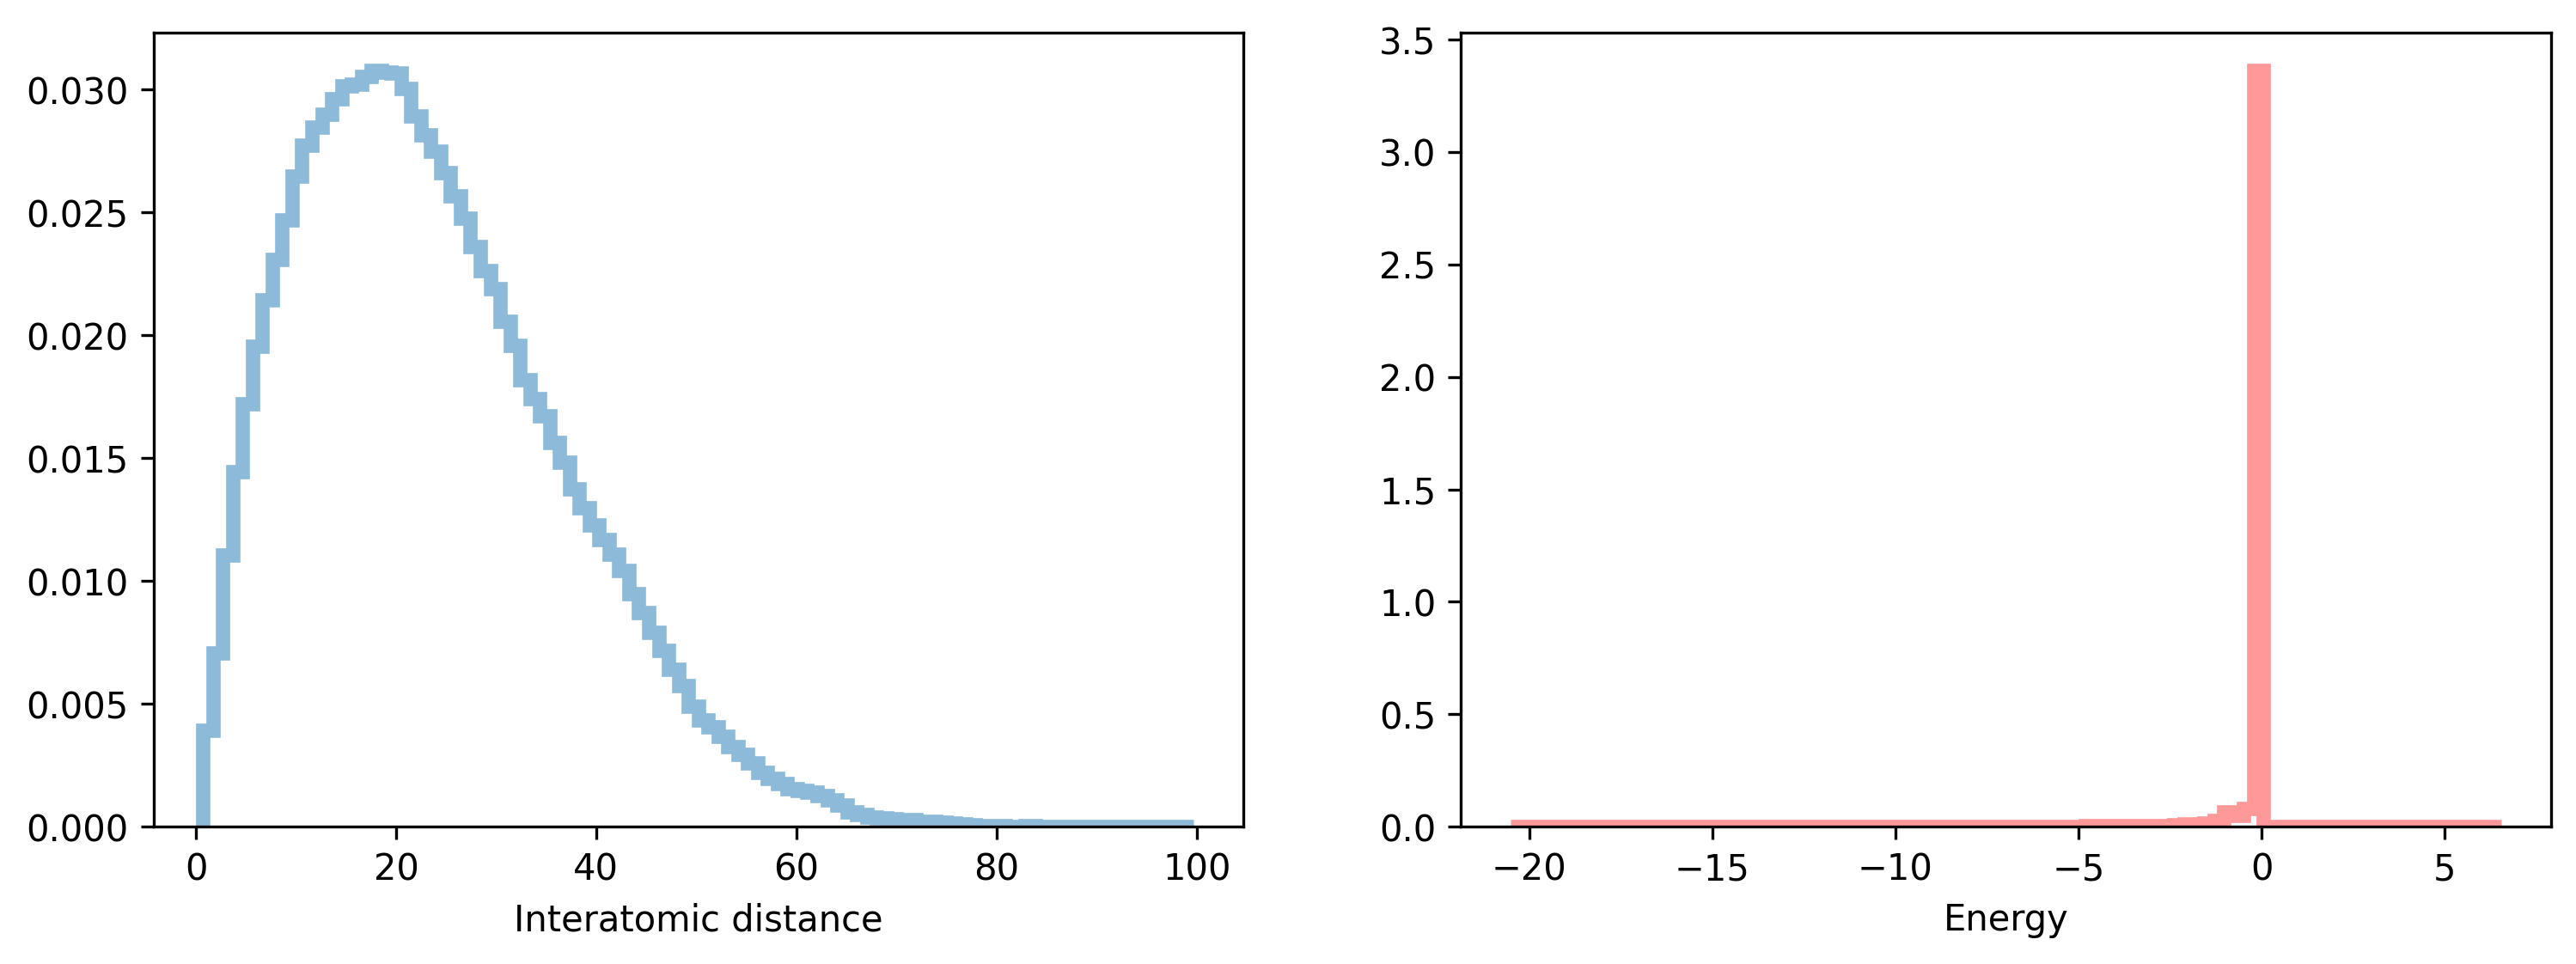

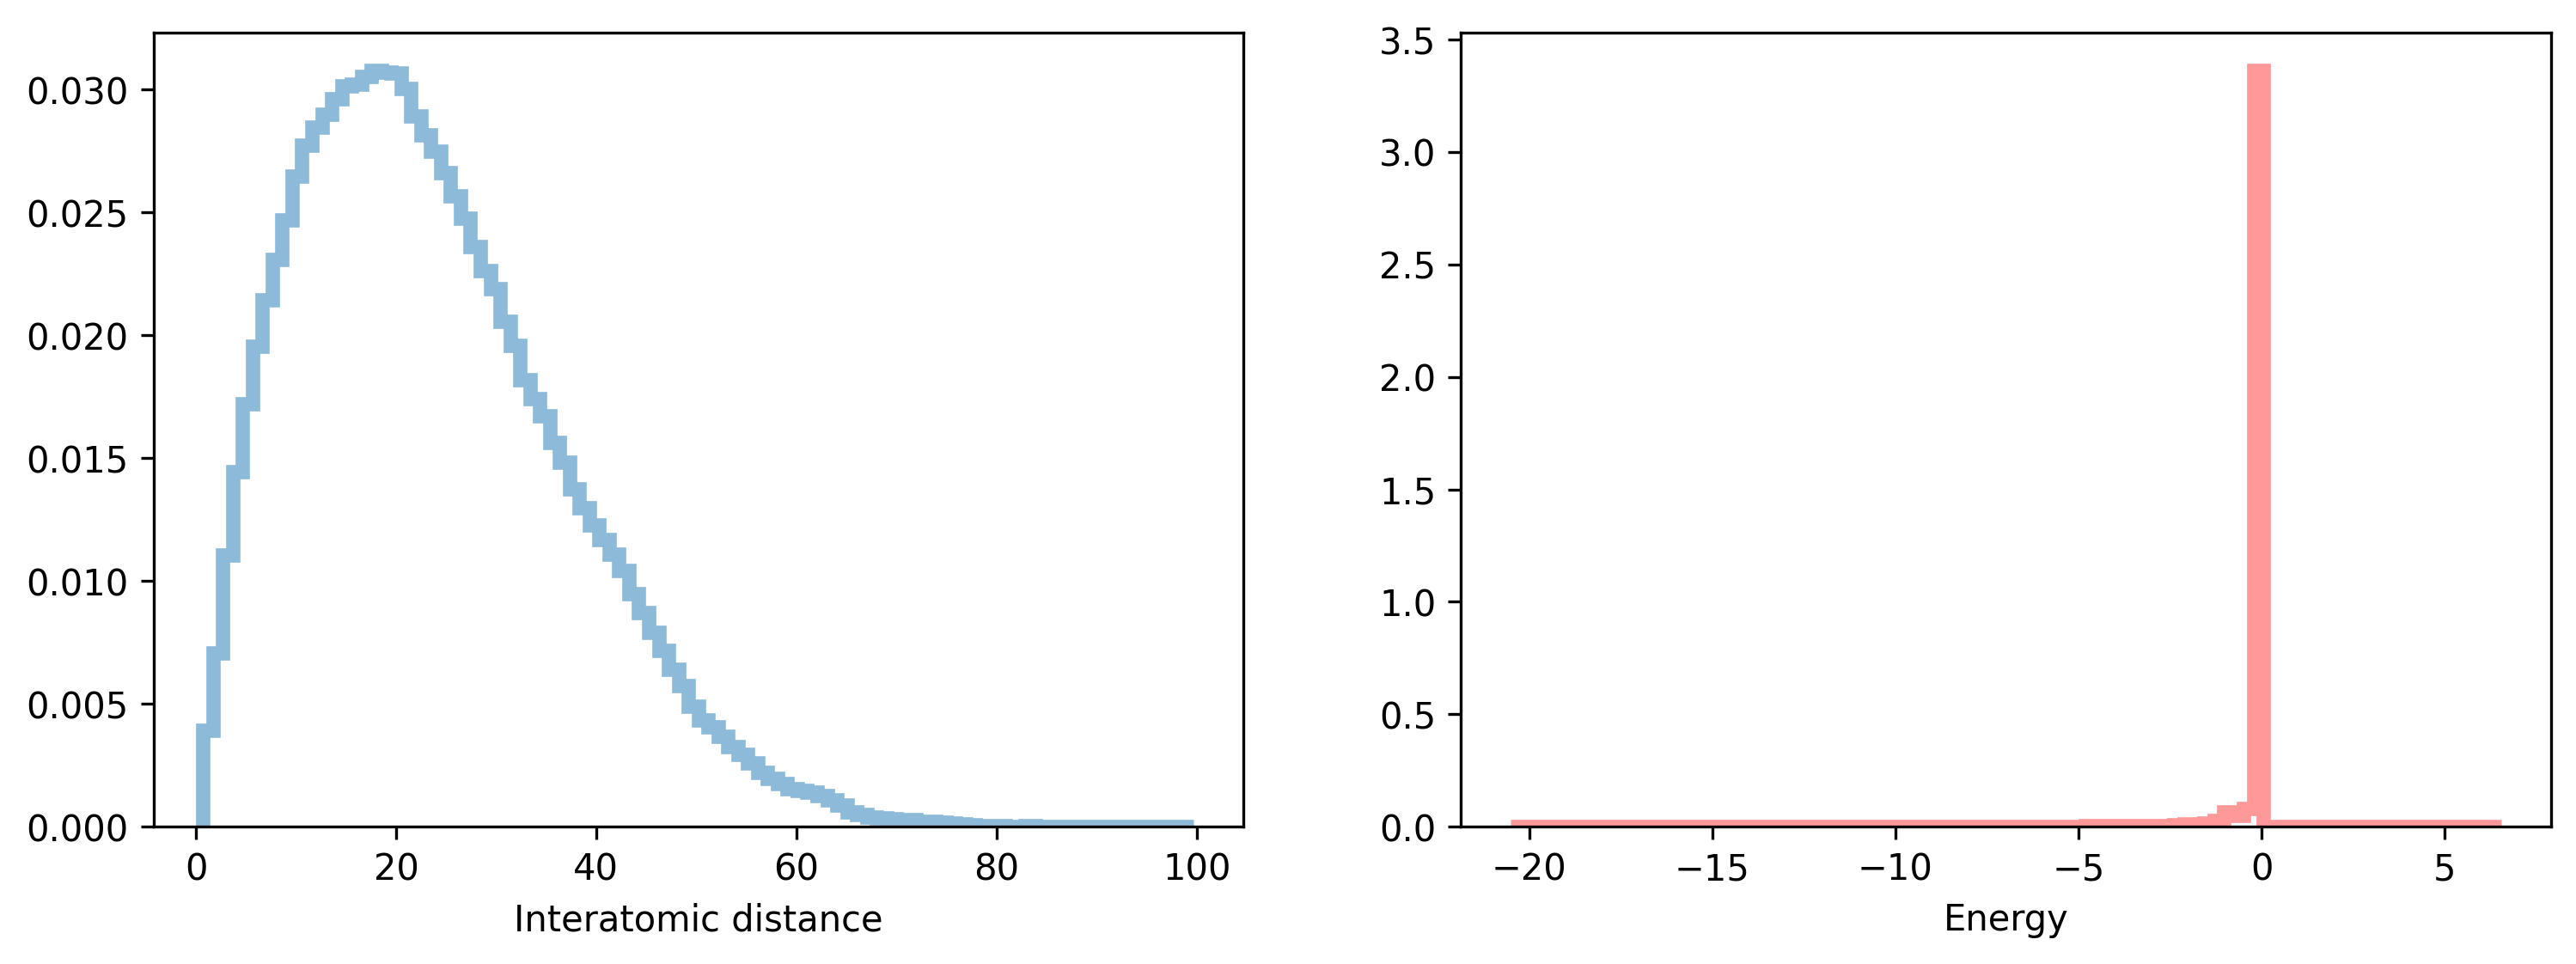

In [221]:
soft_core.visualise(filtered_samples, compare=False)

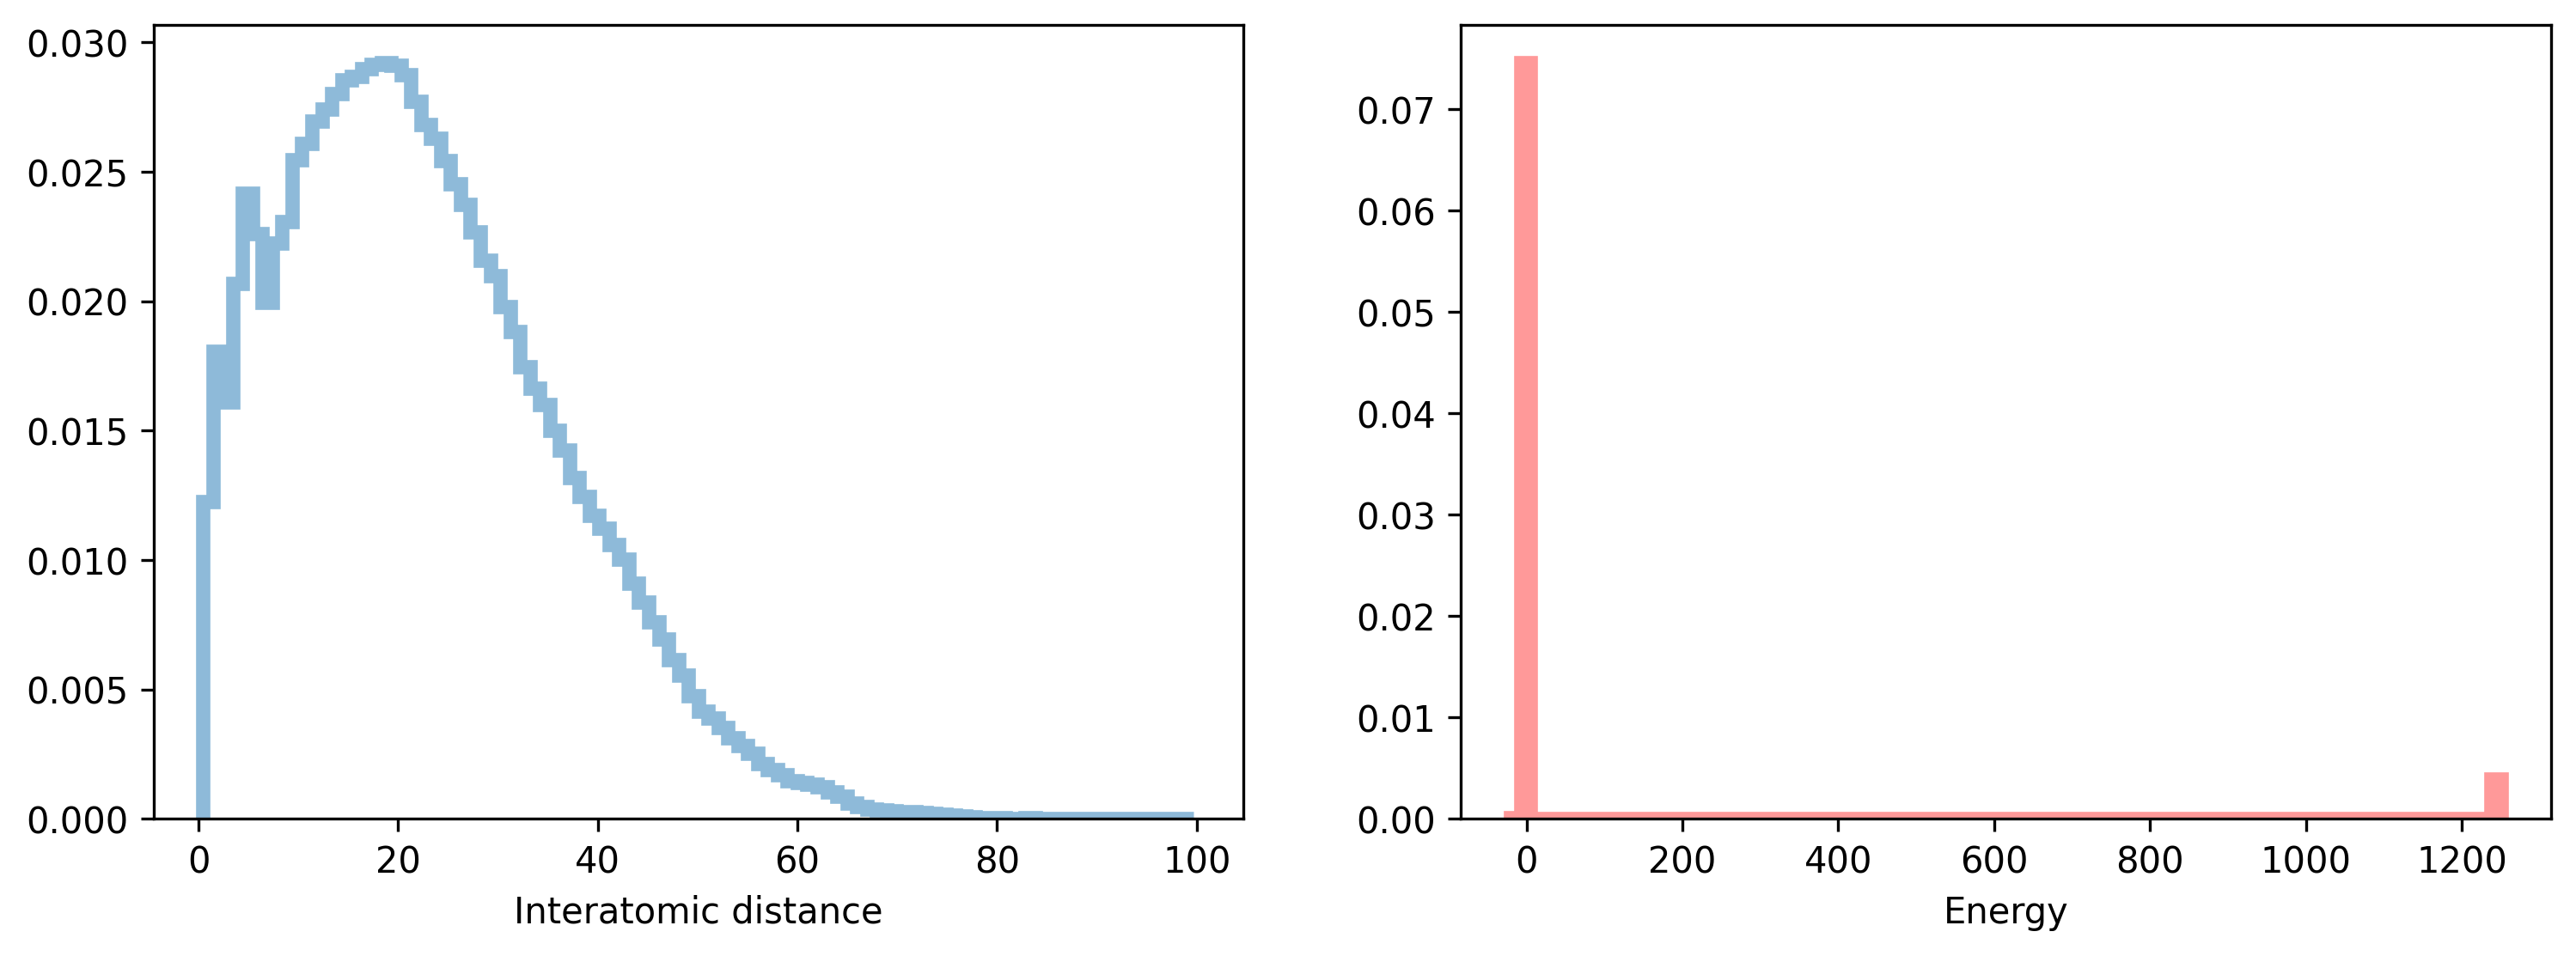

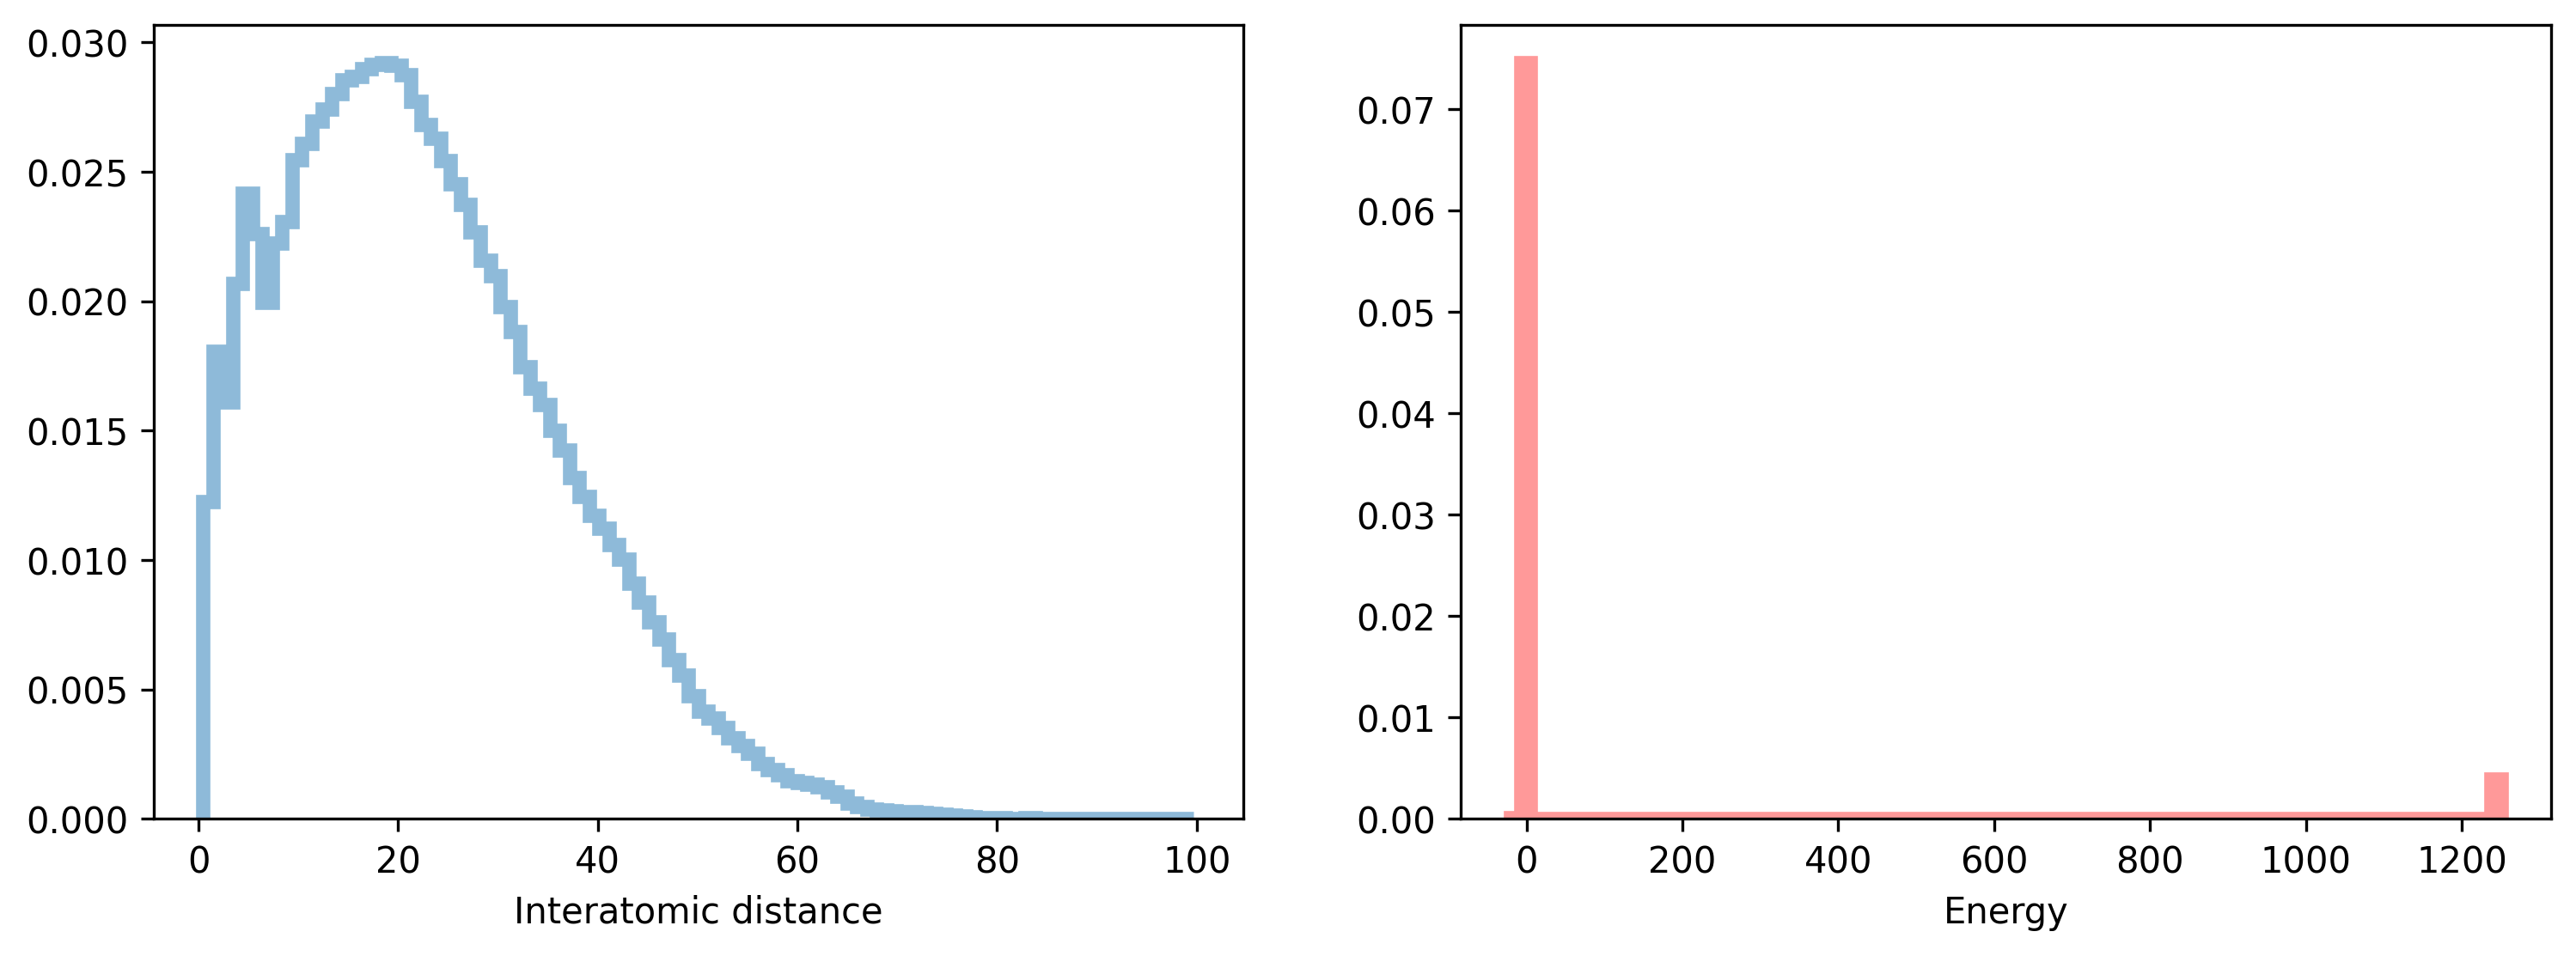

In [219]:
soft_core.visualise(samples, compare=False)

In [141]:
key, subkey = jax.random.split(key)
initial_position = soft_core.initialize_position(subkey)

In [151]:
key, subkey = jax.random.split(key)
samples, info = soft_core._generate_validation_set(key, initial_position=initial_position, step_size=0.01, num_samples=40000, num_warmup=1000, thinning=10)

In [152]:
info

HMCInfo(momentum=Array([ 8.85896564e-01,  2.56283522e+00, -1.12406945e+00, -5.56235790e-01,
       -9.96170700e-01, -6.37657762e-01, -6.77339315e-01, -1.20986974e+00,
        4.71755475e-01, -1.17104483e+00, -7.35467970e-01, -2.00271666e-01,
       -1.07358485e-01,  8.19815874e-01,  3.72518748e-01,  4.12519783e-01,
       -9.31027889e-01, -1.01826990e+00,  3.15752953e-01, -3.81080031e-01,
       -7.08652318e-01, -4.85624999e-01,  1.44870472e+00,  9.64984149e-02,
        2.50980675e-01, -6.12150878e-02, -2.03296900e+00, -4.37558979e-01,
        1.36036128e-01, -9.98945475e-01, -2.41229191e-01,  1.86823273e+00,
        3.96322310e-01, -2.95995325e-01,  1.38035452e+00,  1.67046857e+00,
       -1.62928820e+00, -7.78692544e-01, -2.04739580e-03], dtype=float32), acceptance_rate=Array(0.99999434, dtype=float32), is_accepted=Array(True, dtype=bool), is_divergent=Array(False, dtype=bool), energy=Array(18.783377, dtype=float32), proposal=IntegratorState(position=Array([-10.907816 , -18.601578 , 

In [153]:
samples.shape

(4000, 39)

In [154]:
samples[-1000]

Array([ -0.5421099 , -18.355545  ,  -5.1109333 ,   8.985625  ,
         4.550726  ,  16.993853  ,   1.2586006 ,  28.754911  ,
       -10.110023  ,  11.1464    ,  17.019962  ,  14.481396  ,
        -1.9137883 ,  -2.622245  ,   0.36367506,  -4.4375205 ,
        -5.2750216 ,  -8.531041  ,   6.2704644 ,  -0.49127722,
       -18.34685   , -27.426092  ,  -8.211535  ,  -7.519272  ,
        -8.756236  ,  22.900267  ,  11.114751  ,   1.2108935 ,
       -24.361034  ,   0.7977584 ,   4.394169  ,  -5.5958843 ,
        -6.2168236 ,  -3.9795747 ,  -8.46969   ,  10.811956  ,
        13.789169  ,   0.15637109,   1.2715523 ], dtype=float32)

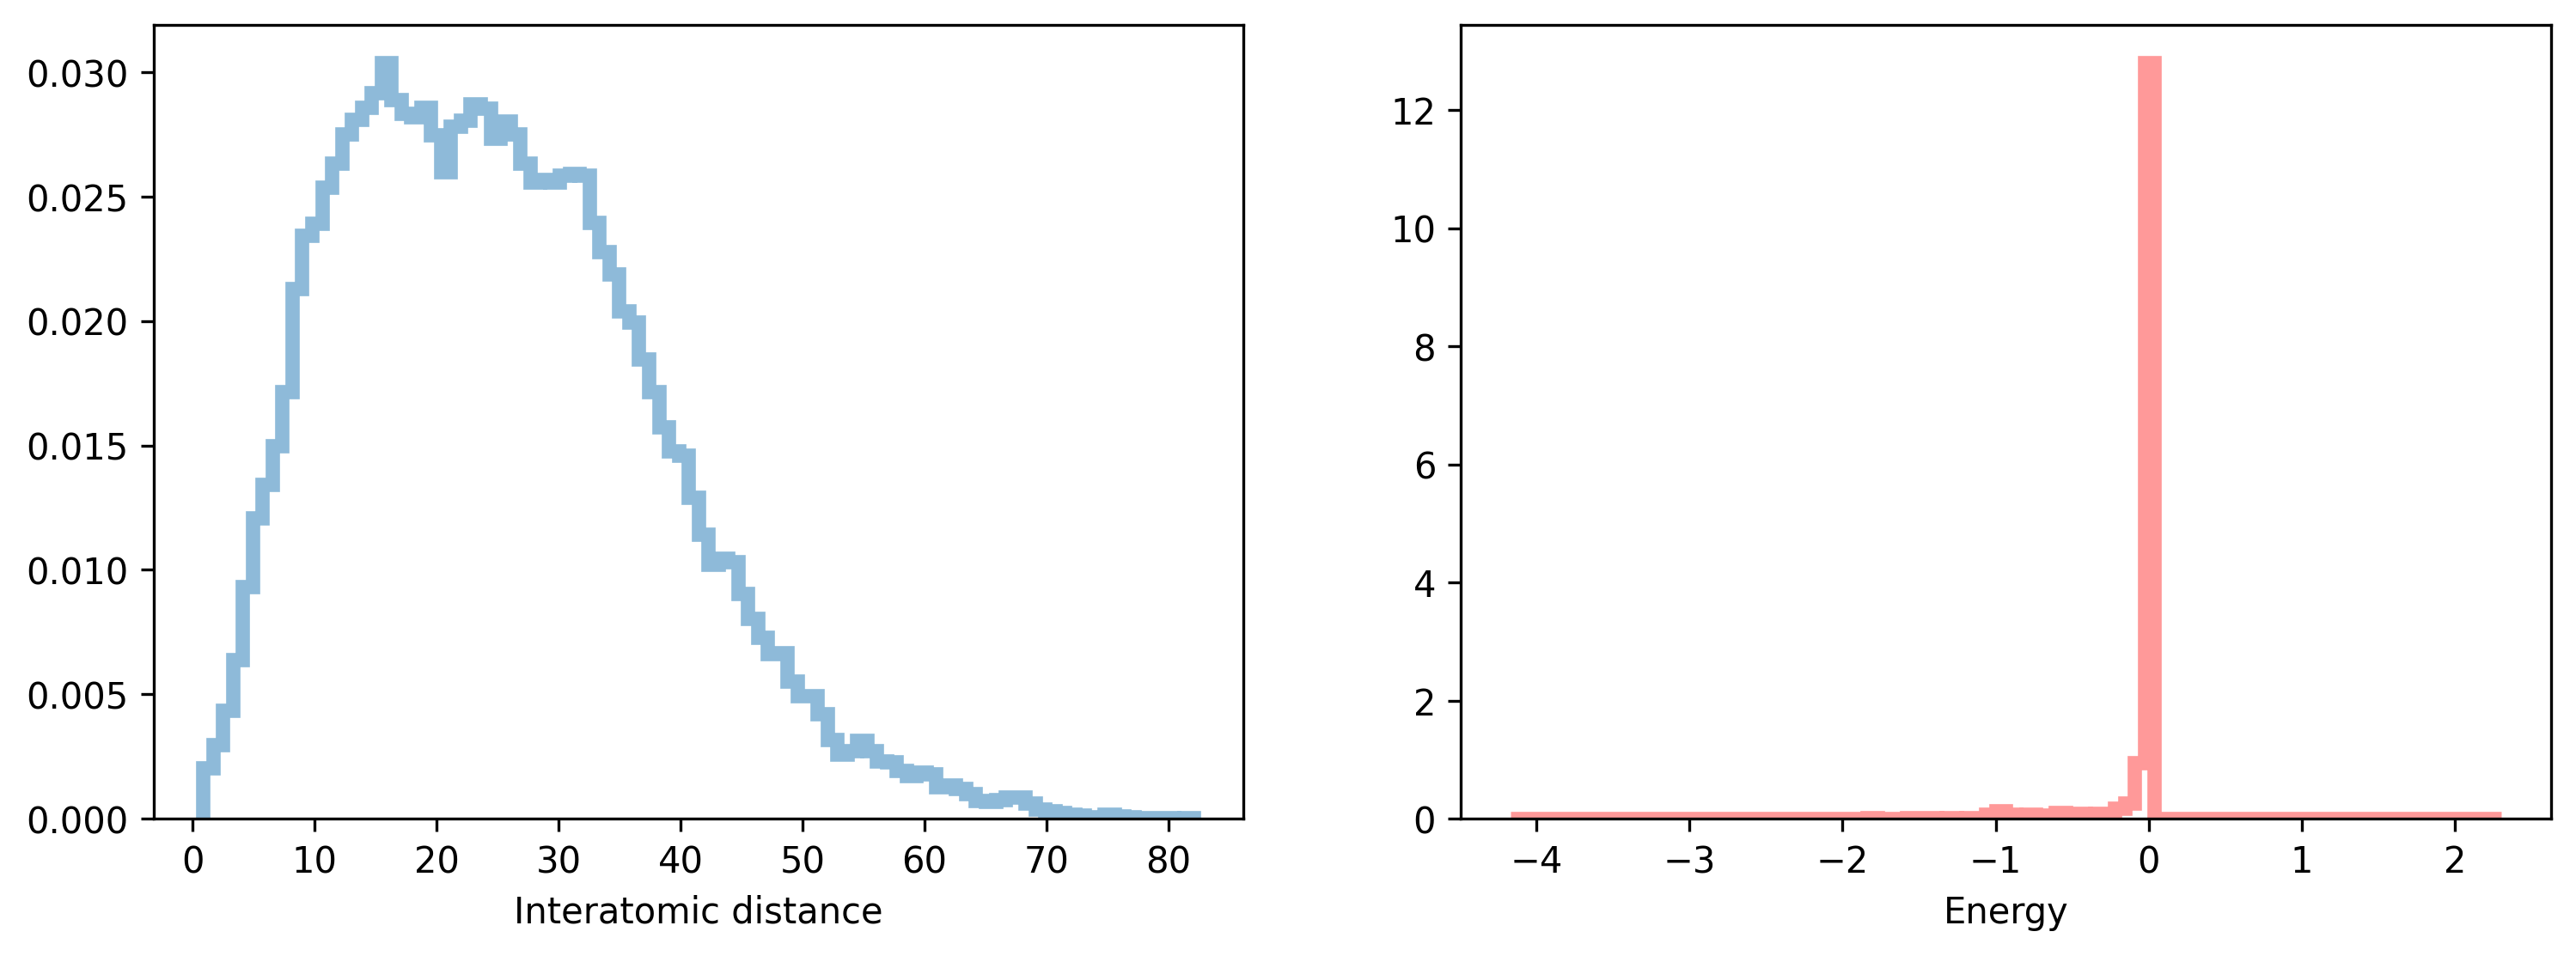

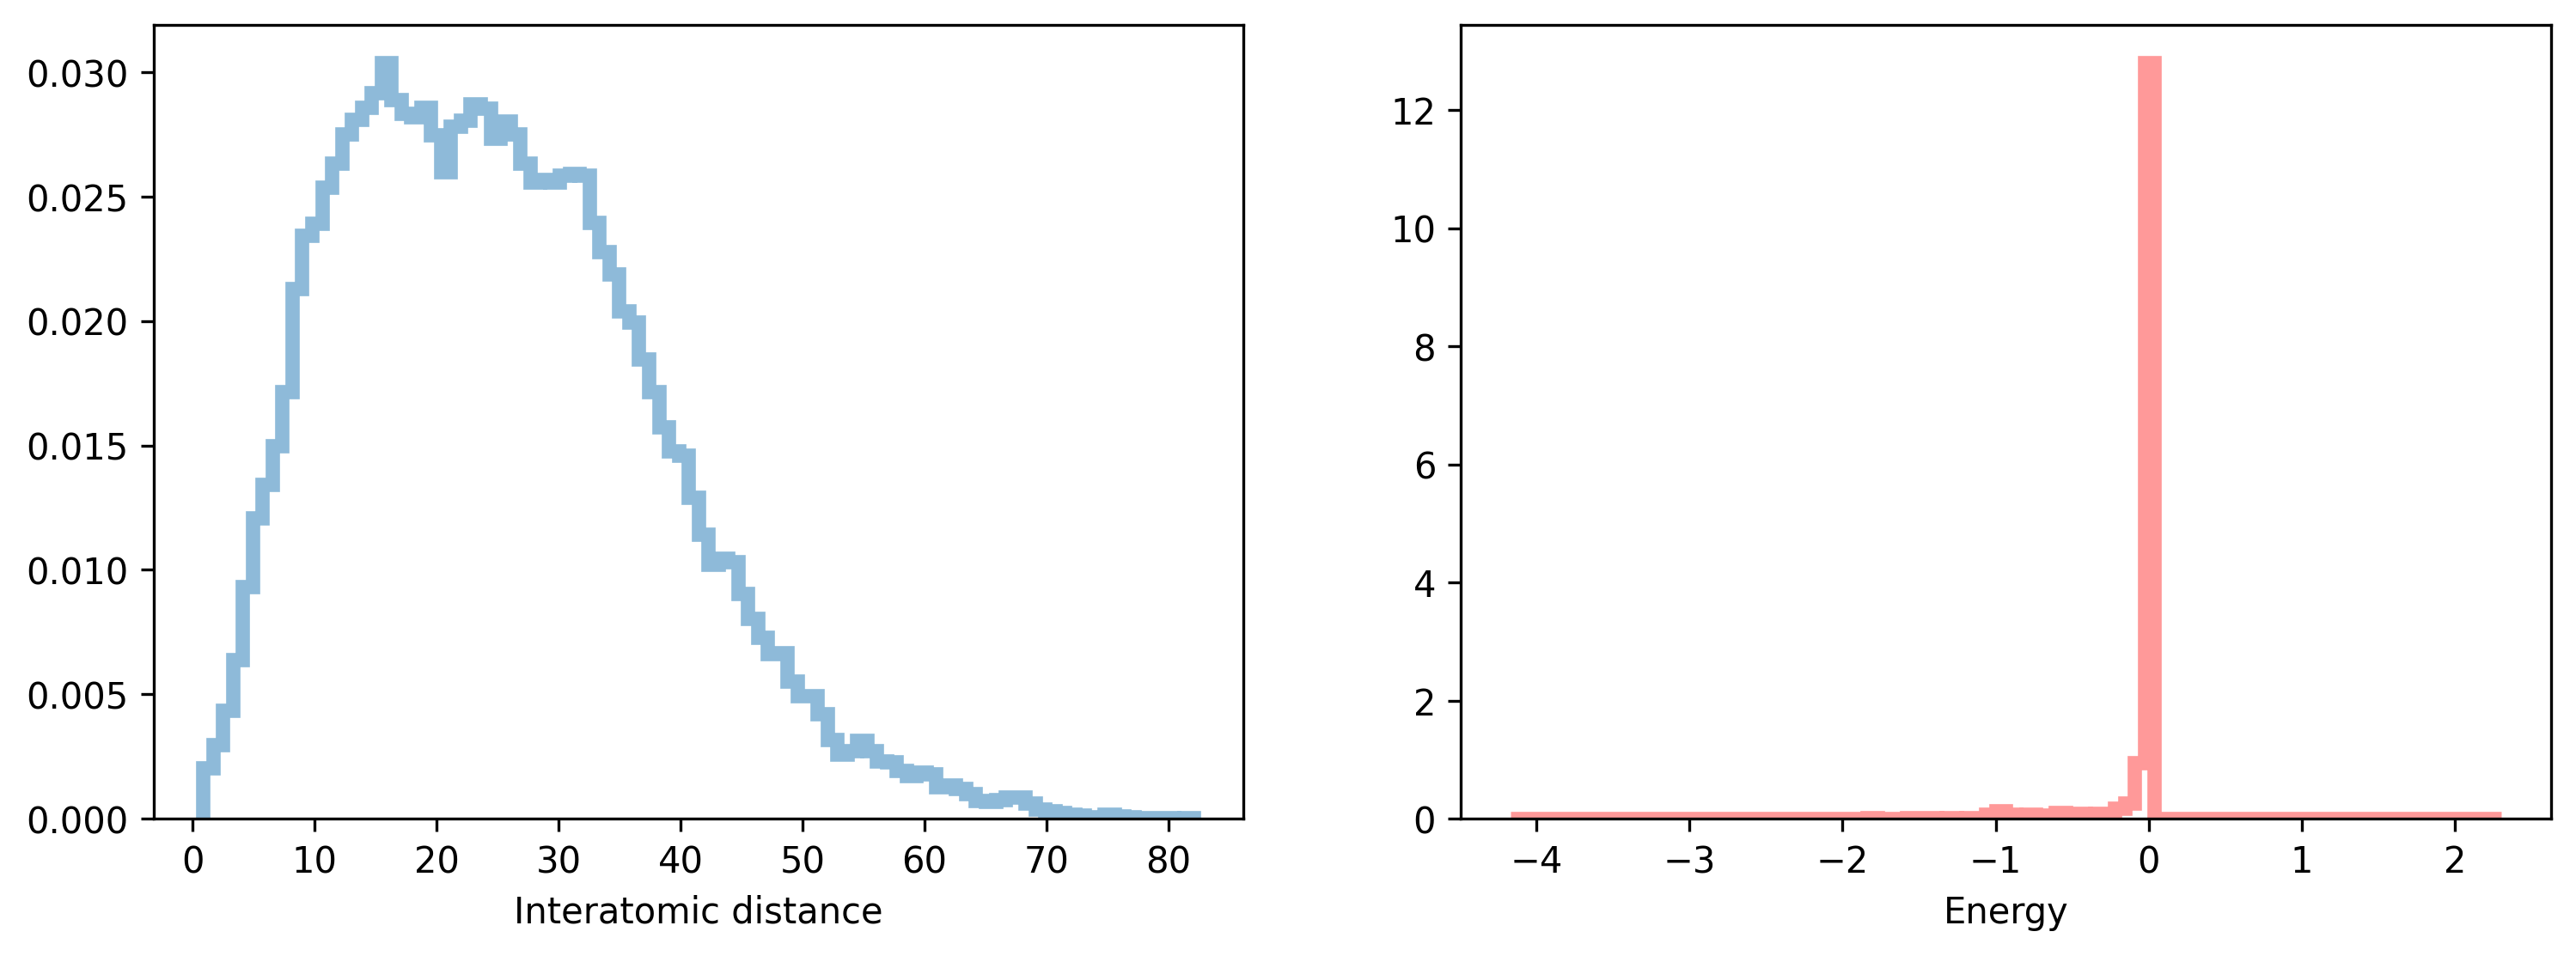

In [155]:
soft_core.visualise(samples, compare=False)

In [140]:
samples[100]

Array([ -0.83604944,   1.3711201 ,  -1.7252836 ,   1.8776987 ,
         0.67341876,   0.52169716,  -0.60055786,   1.3847347 ,
         0.7994963 ,  -1.3787637 ,   0.42398202,   0.04352312,
        -0.4696277 ,  -0.5734198 ,   2.2350779 ,   1.3869824 ,
         0.3756996 ,  -1.6651013 ,   0.90334237,  -0.12913656,
        -0.06041627, -18.997458  , -14.077609  ,  26.482416  ,
        17.760836  ,  11.368531  , -25.52109   ,   1.3690019 ,
         1.4258957 ,  -0.6441098 ,  -1.4424471 ,  -0.14201829,
         0.8149071 ,   0.52416015,   1.162769  ,  -0.27962482,
        -0.09711807,  -3.263967  ,  -1.0014918 ], dtype=float32)

### TimeDependentLennardJonesEnergyButler


In [12]:
def remove_mean(x, n_particles, n_spatial_dim):
    x = x.reshape(n_particles, n_spatial_dim)
    x = x - jnp.mean(x, axis=0, keepdims=True)
    return x.reshape(n_particles * n_spatial_dim)

In [26]:
butler = TimeDependentLennardJonesEnergyButler(
    dim=39,
    n_particles=13,
    alpha=0.2,
    sigma=1.0,
    epsilon_val=1.0,
    min_dr=1e-8,
    n=1,
    m=1,
    log_prob_clip=1000.0,
)

In [42]:
key, subkey = jax.random.split(key)
initial_position = butler.initialize_position(subkey)
inverse_mass_matrix = jnp.ones(39)
step_size = 0.01
num_integration_steps = 4
n_particles = 13
n_spatial_dim = 3
num_samples = 20000


In [43]:
# Setup NUTS sampler
nuts = blackjax.hmc(butler.log_prob, inverse_mass_matrix=inverse_mass_matrix, step_size=step_size, num_integration_steps=num_integration_steps)
nuts = nuts._replace(
    step=remove_mean_decorator(nuts.step, n_particles, n_spatial_dim)
)

initial_state = nuts.init(initial_position)

@jax.jit
def one_step(carry, key):
    state, info = carry
    state, info = nuts.step(key, state)
    return (state, info), state.position

# Generate samples
keys = jax.random.split(key, num_samples)

initial_state, initial_info = nuts.step(keys[0], initial_state)
(final_state, final_info), samples = jax.lax.scan(one_step, (initial_state, initial_info), keys)

NameError: name 'remove_mean_decorator' is not defined

In [151]:
key, subkey = jax.random.split(key)
butler.time_dependent_log_prob(jax.random.normal(subkey, (39, )), 1.)

Array(-1000., dtype=float32)

### Time dependent LJ

In [20]:
class TimeDependentLennardJonesEnergy(Target):
    TIME_DEPENDENT = True

    def __init__(
        self,
        dim: int,
        n_particles: int,
        alpha: float = 0.5,
        sigma: float = 1.0,
        epsilon_val: float = 1.0,
        min_dr: float = 1e-2,
    ):
        super().__init__(
            dim=dim,
            log_Z=None,
            can_sample=False,
            n_plots=10,
            n_model_samples_eval=1000,
            n_target_samples_eval=None,
        )
        self.n_particles = n_particles
        self.n_spatial_dim = dim // n_particles

        self.alpha = alpha
        self.sigma = sigma
        self.epsilon_val = epsilon_val
        self.min_dr = min_dr

    def time_dependent_lennard_jones_potential(
        self,
        pairwise_dr: jnp.ndarray,
        t: float,
    ) -> jnp.ndarray:
        """
        Compute the time-dependent Lennard-Jones potential.

        Args:
            pairwise_dr (jnp.ndarray): Pairwise distances of shape [n_pairs].
            t (float): Time parameter, influencing the strength of the potential.

        Returns:
            jnp.ndarray: Time-dependent Lennard-Jones potential energy of shape [].
        """
        # Compute (sigma / r)^6 and (sigma / r)^12
        inv_r6 = (self.sigma / (pairwise_dr + self.alpha * (1 - t))) ** 6
        inv_r12 = inv_r6**2

        # Compute LJ potential: 4 * epsilon * (inv_r12 - inv_r6)
        lj_energy = 4 * self.epsilon_val * (inv_r12 - inv_r6)

        # Sum over all pairs to get total energy per sample
        total_lj_energy = jnp.sum(lj_energy, axis=-1)

        return total_lj_energy

    def compute_distances(self, x, epsilon=1e-8):
        x = x.reshape(self.n_particles, self.n_spatial_dim)

        # Get indices of upper triangular pairs
        i, j = jnp.triu_indices(self.n_particles, k=1)

        # Calculate displacements between pairs
        dx = x[i] - x[j]

        # Compute distances
        distances = jnp.maximum(
            jnp.sqrt(jnp.sum(dx**2, axis=-1) + epsilon), self.min_dr
        )

        return distances

    def compute_time_dependent_lj_energy(
        self,
        x: jnp.ndarray,
        t: float,
    ) -> jnp.ndarray:
        """
        Compute the total time-dependent Lennard-Jones energy for a batch of samples.

        Args:
            x (jnp.ndarray): Input array of shape [n_particles * n_spatial_dim].
            t (float): Time parameter.

        Returns:
            jnp.ndarray: Total time-dependent Lennard-Jones energy.
        """
        pairwise_dr = self.compute_distances(
            x.reshape(self.n_particles, self.n_spatial_dim)
        )
        lj_energy = self.time_dependent_lennard_jones_potential(pairwise_dr, t)
        return lj_energy

    def log_prob(self, x: chex.Array) -> chex.Array:
        return -self.compute_time_dependent_lj_energy(x, 1.)

    def time_dependent_log_prob(self, x: chex.Array, t: float) -> chex.Array:
        return -self.compute_time_dependent_lj_energy(x, t)

    def score(self, x: chex.Array, t: float) -> chex.Array:
        return jax.grad(self.log_prob, argnums=0)(x, t)

    def sample(
        self, key: jax.random.PRNGKey, sample_shape: chex.Shape = ()
    ) -> chex.Array:
        raise NotImplementedError(
            "Sampling is not implemented for TimeDependentLennardJonesEnergy"
        )

    def interatomic_dist(self, x):
        x = x.reshape(-1, self.n_particles, self.n_spatial_dim)
        distances = jax.vmap(lambda x: self.compute_distances(x))(x)

        return distances

    def batched_log_prob(self, xs, t):
        return jax.vmap(self.time_dependent_log_prob, in_axes=(0, None))(xs, t)

    def visualise(self, samples: chex.Array) -> plt.Figure:
        # Since we don't have a test set, we will just visualize the samples
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        dist_samples = self.interatomic_dist(samples)

        axs[0].hist(
            dist_samples.flatten(),
            bins=100,
            alpha=0.5,
            density=True,
            histtype="step",
            linewidth=4,
        )
        axs[0].set_xlabel("Interatomic distance")
        axs[0].legend(["Generated data"])

        energy_samples = -self.batched_log_prob(samples, 1.0)

        min_energy = -26
        max_energy = 0

        axs[1].hist(
            energy_samples,
            bins=100,
            density=True,
            alpha=0.4,
            range=(min_energy, max_energy),
            color="r",
            histtype="step",
            linewidth=4,
            label="Generated data",
        )
        axs[1].set_xlabel("Energy")
        axs[1].legend()

        fig.canvas.draw()
        return fig

In [21]:
lj = TimeDependentLennardJonesEnergy(
    dim=39,
    n_particles=13,
    alpha=0.5,
    sigma=1.0,
    epsilon_val=1.0,
    min_dr=1e-4,
)

In [22]:
key, subkey = jax.random.split(key)
samples = jax.random.normal(subkey, (1000, 39))

### Butler

In [5]:
from jax.scipy.optimize import minimize

class TimeDependentLennardJonesEnergyButler(Target):
    TIME_DEPENDENT = True

    def __init__(
        self,
        dim: int,
        n_particles: int,
        alpha: float = 0.5,
        sigma: float = 1.0,
        epsilon_val: float = 1.0,
        min_dr: float = 1e-4,
        n: float = 1,
        m: float = 1,
        c: float = 0.5,
        log_prob_clip: float = None,
        score_norm: float = 1.0,
        data_path_val: str = "../data/val_split_LJ13-1000.npy",
    ):
        super().__init__(
            dim=dim,
            log_Z=None,
            can_sample=False,
            n_plots=10,
            n_model_samples_eval=1000,
            n_target_samples_eval=None,
        )
        self.n_particles = n_particles
        self.n_spatial_dim = dim // n_particles

        self.alpha = alpha
        self.sigma = sigma
        self.epsilon_val = epsilon_val
        self.min_dr = min_dr
        self.n = n
        self.m = m
        self.c = c

        self.log_prob_clip = log_prob_clip
        self.score_norm = score_norm

        self.data_path_val = data_path_val

        self._val_set = self.setup_val_set()

    def setup_val_set(self):
        data = np.load(self.data_path_val, allow_pickle=True)
        return data

    def find_min_energy_position(self, initial_position, tol=1e-6):
        result = minimize(lambda x: self.compute_time_dependent_lj_energy(x, 1.0), initial_position, method="BFGS", tol=tol)
        return result.x

    def initialize_position(self, key: jax.random.PRNGKey):
        # Start with a random normal position
        initial_position = jax.random.normal(key, (self.dim,))
        # Optionally, scale positions to avoid overlaps
        initial_position = initial_position * self.sigma * 1.1
        # Perform energy minimization
        optimized_position = self.find_min_energy_position(initial_position)

        # Center the initial position
        optimized_position = remove_mean(optimized_position, self.n_particles, self.n_spatial_dim)
        
        return optimized_position
    
    def _generate_validation_set(self, key: jax.random.PRNGKey, initial_position, inverse_mass_matrix=None, step_size=0.01, num_samples=1000, num_warmup=1000, thinning=10, num_integration_steps=10, divergence_threshold=10000):
        """Generate validation set using NUTS sampler"""
        if inverse_mass_matrix is None:
            inverse_mass_matrix = jnp.ones(self.dim)
        # Setup NUTS sampler
        nuts = blackjax.hmc(self.log_prob, inverse_mass_matrix=inverse_mass_matrix, divergence_threshold=divergence_threshold, step_size=step_size, num_integration_steps=num_integration_steps)
        # nuts = nuts._replace(
        #     step=remove_mean_decorator(nuts.step, self.n_particles, self.n_spatial_dim)
        # )
        
        initial_state = nuts.init(initial_position)

        @jax.jit
        def one_step(carry, key):
            state, info = carry
            state, info = nuts.step(key, state)
            return (state, info), state.position

        # Generate samples
        keys = jax.random.split(key, num_samples + num_warmup)

        initial_state, initial_info = nuts.step(keys[0], initial_state)
        (final_state, final_info), samples = jax.lax.scan(one_step, (initial_state, initial_info), keys)
        
        # Apply thinning and discard warmup
        samples = samples[:num_warmup]
        samples = samples[::thinning]

        # Apply shift function and center of mass correction
        # samples = self.shift_fn(samples)
        samples = jax.vmap(lambda samples: remove_mean(samples, self.n_particles, self.n_spatial_dim))(samples)
        
        return samples, final_info

    def multichain_sampling(self, key: jax.random.PRNGKey, inverse_mass_matrix=None, num_chains=10, step_size=0.01, num_samples=1000, num_warmup=1000, thinning=10, num_integration_steps=10, divergence_threshold=10000):
        """Generate multiple chains using NUTS sampler"""

        keys = jax.random.split(key, num_chains)
        initial_positions = jax.vmap(self.initialize_position)(keys)

        if inverse_mass_matrix is None:
            inverse_mass_matrix = jnp.ones(self.dim)

        keys = jax.random.split(keys[0], num_chains)
        samples = jax.vmap(lambda key, initial_position: self._generate_validation_set(key, initial_position, inverse_mass_matrix, step_size, num_samples, num_warmup, thinning, num_integration_steps, divergence_threshold)[0])(keys, initial_positions)
        
        return samples.reshape(-1, self.dim)
    
    def soft_core_lennard_jones_potential(
        self,
        pairwise_dr: jnp.ndarray,
        t: float,
    ) -> jnp.ndarray:
        """
        Compute the time-dependent soft-core Lennard-Jones potential.

        Args:
            pairwise_dr (jnp.ndarray): Pairwise distances of shape [n_pairs].
            t (float): Time parameter, influencing the strength of the potential (lambda).

        Returns:
            jnp.ndarray: Time-dependent soft-core Lennard-Jones potential energy of shape [].
        """

        inv_r6 = (self.sigma / (pairwise_dr + self.alpha * (1 - t) ** self.m)) ** 6
        inv_r12 = inv_r6**2

        lj_energy = self.epsilon_val * t ** self.n * (inv_r12 - 2 * inv_r6)
        total_lj_energy = jnp.sum(lj_energy, axis=-1)

        return total_lj_energy
    
    def soft_core_lennard_jones_potential_1(
        self,
        pairwise_dr: jnp.ndarray,
        t: float,
    ) -> jnp.ndarray:
        """
        Compute the time-dependent soft-core Lennard-Jones potential.

        Args:
            pairwise_dr (jnp.ndarray): Pairwise distances of shape [n_pairs].
            t (float): Time parameter, influencing the strength of the potential (lambda).

        Returns:
            jnp.ndarray: Time-dependent soft-core Lennard-Jones potential energy of shape [].
        """

        # U(λ, r) = 0.5 * epsilon * λ^n * [ (α_LJ * (1 - λ)^m + (r/sigma)^6)^-2 - (α_LJ * (1 - λ)^m + (r/sigma)^6)^-1 ]
        lambda_ = t

        inv_r6 = (pairwise_dr / self.sigma) ** 6
        soft_core_term = self.alpha * (1 - lambda_) ** self.m + inv_r6
        lj_energy = (
            0.5
            * self.epsilon_val
            * lambda_**self.n
            * (soft_core_term**-1 - soft_core_term**-2)
        )

        # Sum over all pairs to get total energy per sample
        total_lj_energy = jnp.sum(lj_energy, axis=-1)

        return total_lj_energy

    def compute_distances(self, x, epsilon=1e-8):
        x = x.reshape(self.n_particles, self.n_spatial_dim)

        # Get indices of upper triangular pairs
        i, j = jnp.triu_indices(self.n_particles, k=1)

        # Calculate displacements between pairs
        dx = x[i] - x[j]

        # Compute distances
        distances = optax.safe_norm(dx, axis=-1, min_norm=self.min_dr)

        return distances

    def harmonic_potential(self, x):
        """
        Compute the harmonic potential energy.

        E^osc(x) = 1/2 * Σ ||xi - x_COM||^2
        """
        x = x.reshape(self.n_particles, self.n_spatial_dim)
        x_com = jnp.mean(x, axis=0)
        distances_to_com = optax.safe_norm(
            x - x_com,
            axis=-1,
            min_norm=0.0,
        )

        return 0.5 * jnp.sum(distances_to_com**2)

    def compute_time_dependent_lj_energy(
        self,
        x: jnp.ndarray,
        t: float,
    ) -> jnp.ndarray:
        """
        Compute the total time-dependent soft-core Lennard-Jones energy for a batch of samples.

        Args:
            x (jnp.ndarray): Input array of shape [n_particles * n_spatial_dim].
            t (float): Time parameter.

        Returns:
            jnp.ndarray: Total time-dependent Lennard-Jones energy.
        """
        pairwise_dr = self.compute_distances(
            x.reshape(self.n_particles, self.n_spatial_dim)
        )
        lj_energy = self.soft_core_lennard_jones_potential(pairwise_dr, t)
        if self.log_prob_clip is not None:
            lj_energy = jnp.clip(lj_energy, -self.log_prob_clip, self.log_prob_clip)

        harmonic_energy = self.harmonic_potential(x)

        return lj_energy + self.c * harmonic_energy

    def log_prob(self, x: chex.Array) -> chex.Array:
        return -self.compute_time_dependent_lj_energy(x, 1.0)

    def time_dependent_log_prob(self, x: chex.Array, t: float) -> chex.Array:
        p_t = -self.compute_time_dependent_lj_energy(x, t)
        return p_t

    def score(self, x: chex.Array, t: float) -> chex.Array:
        sc = jax.grad(self.time_dependent_log_prob, argnums=0)(x, t)
        norm = optax.safe_norm(sc, axis=-1, min_norm=1e-6)
        scale = jnp.clip(self.score_norm / (norm + 1e-6), a_min=0.0, a_max=1.0)

        return sc * scale

    def sample(
        self, key: jax.random.PRNGKey, sample_shape: chex.Shape = ()
    ) -> chex.Array:
        raise NotImplementedError(
            "Sampling is not implemented for TimeDependentLennardJonesEnergy"
        )

    def interatomic_dist(self, x):
        x = x.reshape(-1, self.n_particles, self.n_spatial_dim)
        distances = jax.vmap(lambda x: self.compute_distances(x))(x)

        return distances

    def batched_log_prob(self, xs, t):
        return jax.vmap(self.time_dependent_log_prob, in_axes=(0, None))(xs, t)

    def visualise(self, samples: chex.Array) -> plt.Figure:
        # Fill samples nan values with zeros
        samples = jnp.nan_to_num(samples, nan=0.0, posinf=100.0, neginf=-100.0)

        # Since we don't have a test set, we will just visualize the samples
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        dist_samples = self.interatomic_dist(samples)
        dist_val = self.interatomic_dist(self._val_set)

        axs[0].hist(
            dist_samples.flatten(),
            bins=100,
            alpha=0.5,
            density=True,
            histtype="step",
            linewidth=4,
        )

        axs[0].hist(
            dist_val.flatten(),
            bins=100,
            alpha=0.5,
            density=True,
            histtype="step",
            linewidth=4,
        )
        axs[0].set_xlabel("Interatomic distance")
        axs[0].legend(["Generated data", "Ground truth samples"])

        energy_samples = -self.batched_log_prob(samples, 1.0)
        energy_samples_val = -self.batched_log_prob(self._val_set, 1.0)

        # Clip energy values for visualization
        energy_samples = jnp.nan_to_num(
            energy_samples, nan=0.0, posinf=1000.0, neginf=-1000.0
        )
        energy_samples_val = jnp.nan_to_num(
            energy_samples_val, nan=0.0, posinf=1000.0, neginf=-1000.0
        )

        # Determine histogram range from cleaned data
        min_energy = jnp.min(jnp.concatenate([energy_samples, energy_samples_val]))
        max_energy = jnp.max(jnp.concatenate([energy_samples, energy_samples_val]))

        # Add padding to range
        energy_range = (min_energy - 0.1*abs(min_energy), 
                    max_energy + 0.1*abs(max_energy))

        axs[1].hist(
            energy_samples,
            bins=100,
            density=True,
            alpha=0.4,
            range=energy_range,
            color="r",
            histtype="step",
            linewidth=4,
            label="Generated data",
        )

        axs[1].hist(
            energy_samples_val,
            bins=100,
            density=True,
            alpha=0.4,
            range=energy_range,
            color="g",
            histtype="step",
            linewidth=4,
            label="Ground truth samples",
        )
        axs[1].set_xlabel("Energy")
        axs[1].legend()

        fig.canvas.draw()
        return fig

In [6]:
butler = TimeDependentLennardJonesEnergyButler(
    dim=39,
    n_particles=13,
    alpha=0,
    sigma=1.0,
    epsilon_val=1.0,
    min_dr=1e-5,
    n=1,
    m=1,
    # log_prob_clip=100.0,
)

In [7]:
key, subkey = jax.random.split(key)
initial_position = butler.initialize_position(subkey)

log_prob = butler.log_prob(initial_position)
print(f"Initial log prob: {log_prob} for position {initial_position}")

inverse_mass_matrix = jnp.ones(39)
step_size = 0.1
num_integration_steps = 4
n_particles = 13
n_spatial_dim = 3

Initial log prob: 8.73835563659668 for position [ 0.09872894 -0.47073823 -0.576143   -1.7753795  -2.5689445   0.3378314
 -0.80763614  0.46311724  0.96138954  0.9310037  -0.3698169   0.6574534
 -0.78295076  0.15265423 -0.19775316  0.8309009   0.9895196   0.6873152
  0.7595464   2.4727979  -0.786608    0.9463023  -0.08043206 -0.2619433
  0.3947241  -0.95323545  0.09677804 -0.29948586  2.074195   -0.08822736
  0.23506397 -0.9853311  -1.3223966   0.02989082  0.05849538  0.3386664
 -0.56070864 -0.782281    0.15363654]


In [8]:
key, subkey = jax.random.split(key)
samples = butler.multichain_sampling(subkey, inverse_mass_matrix=None, num_chains=20, step_size=0.1, num_samples=210000, num_warmup=200000, thinning=1, num_integration_steps=5)

In [9]:
samples.shape

(4000000, 39)

In [284]:
num_samples = 210000

# Setup NUTS sampler
# nuts = blackjax.mala(butler.log_prob, step_size=step_size)
nuts = blackjax.hmc(butler.log_prob, inverse_mass_matrix=inverse_mass_matrix, step_size=step_size, num_integration_steps=num_integration_steps)
# nuts = nuts._replace(
#     step=remove_mean_decorator(nuts.step, n_particles, n_spatial_dim)
# )

initial_state = nuts.init(initial_position)

@jax.jit
def one_step(carry, key):
    state, info = carry
    state, info = nuts.step(key, state)
    return (state, info), state.position

# Generate samples
keys = jax.random.split(key, num_samples)

initial_state, initial_info = nuts.step(keys[0], initial_state)
(final_state, final_info), samples = jax.lax.scan(one_step, (initial_state, initial_info), keys)

In [285]:
samples[200000:].shape

(10000, 39)

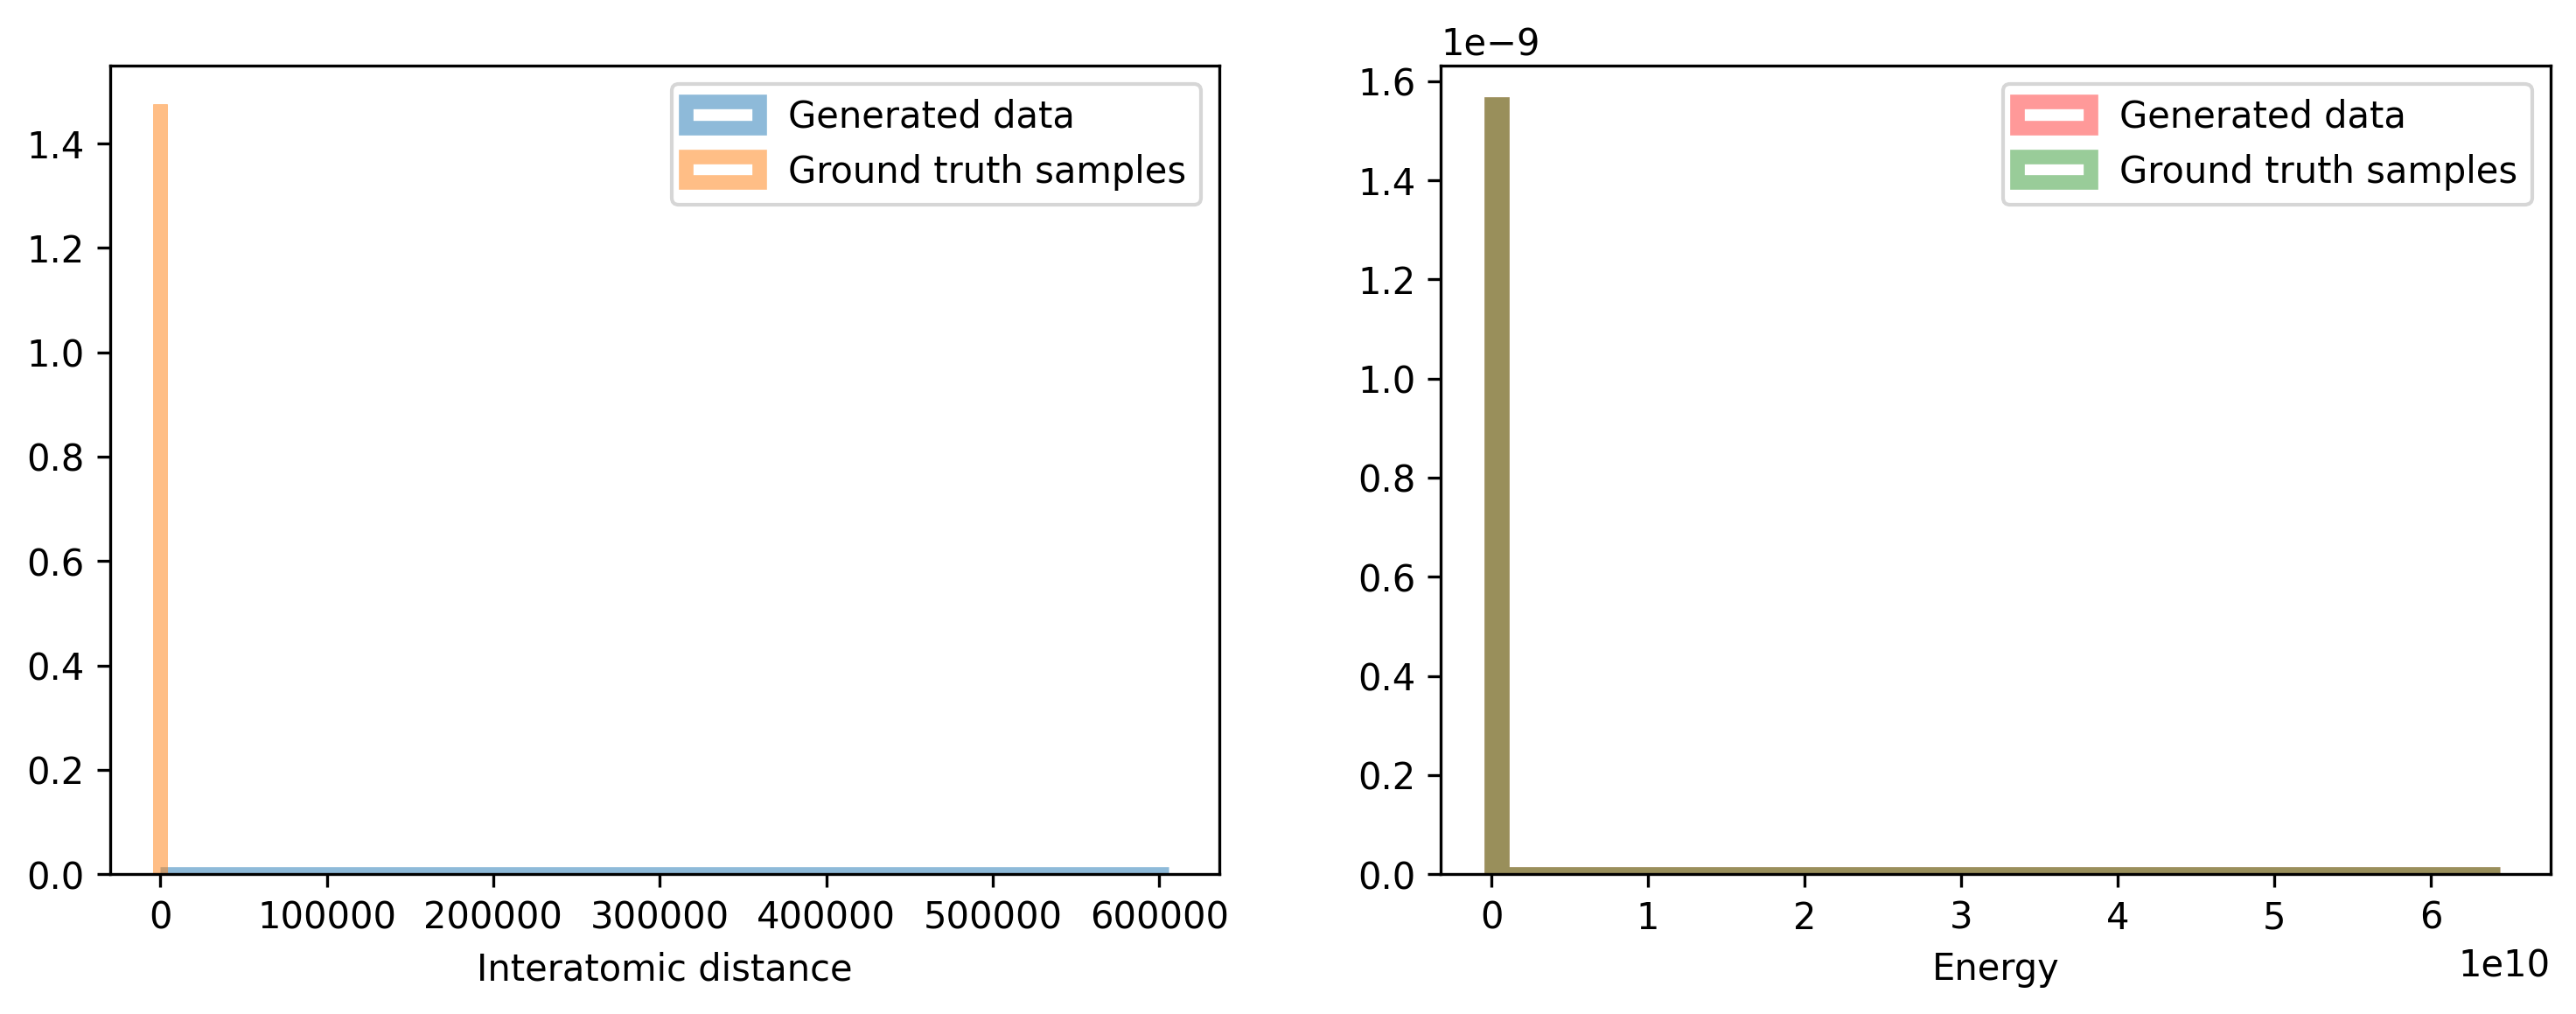

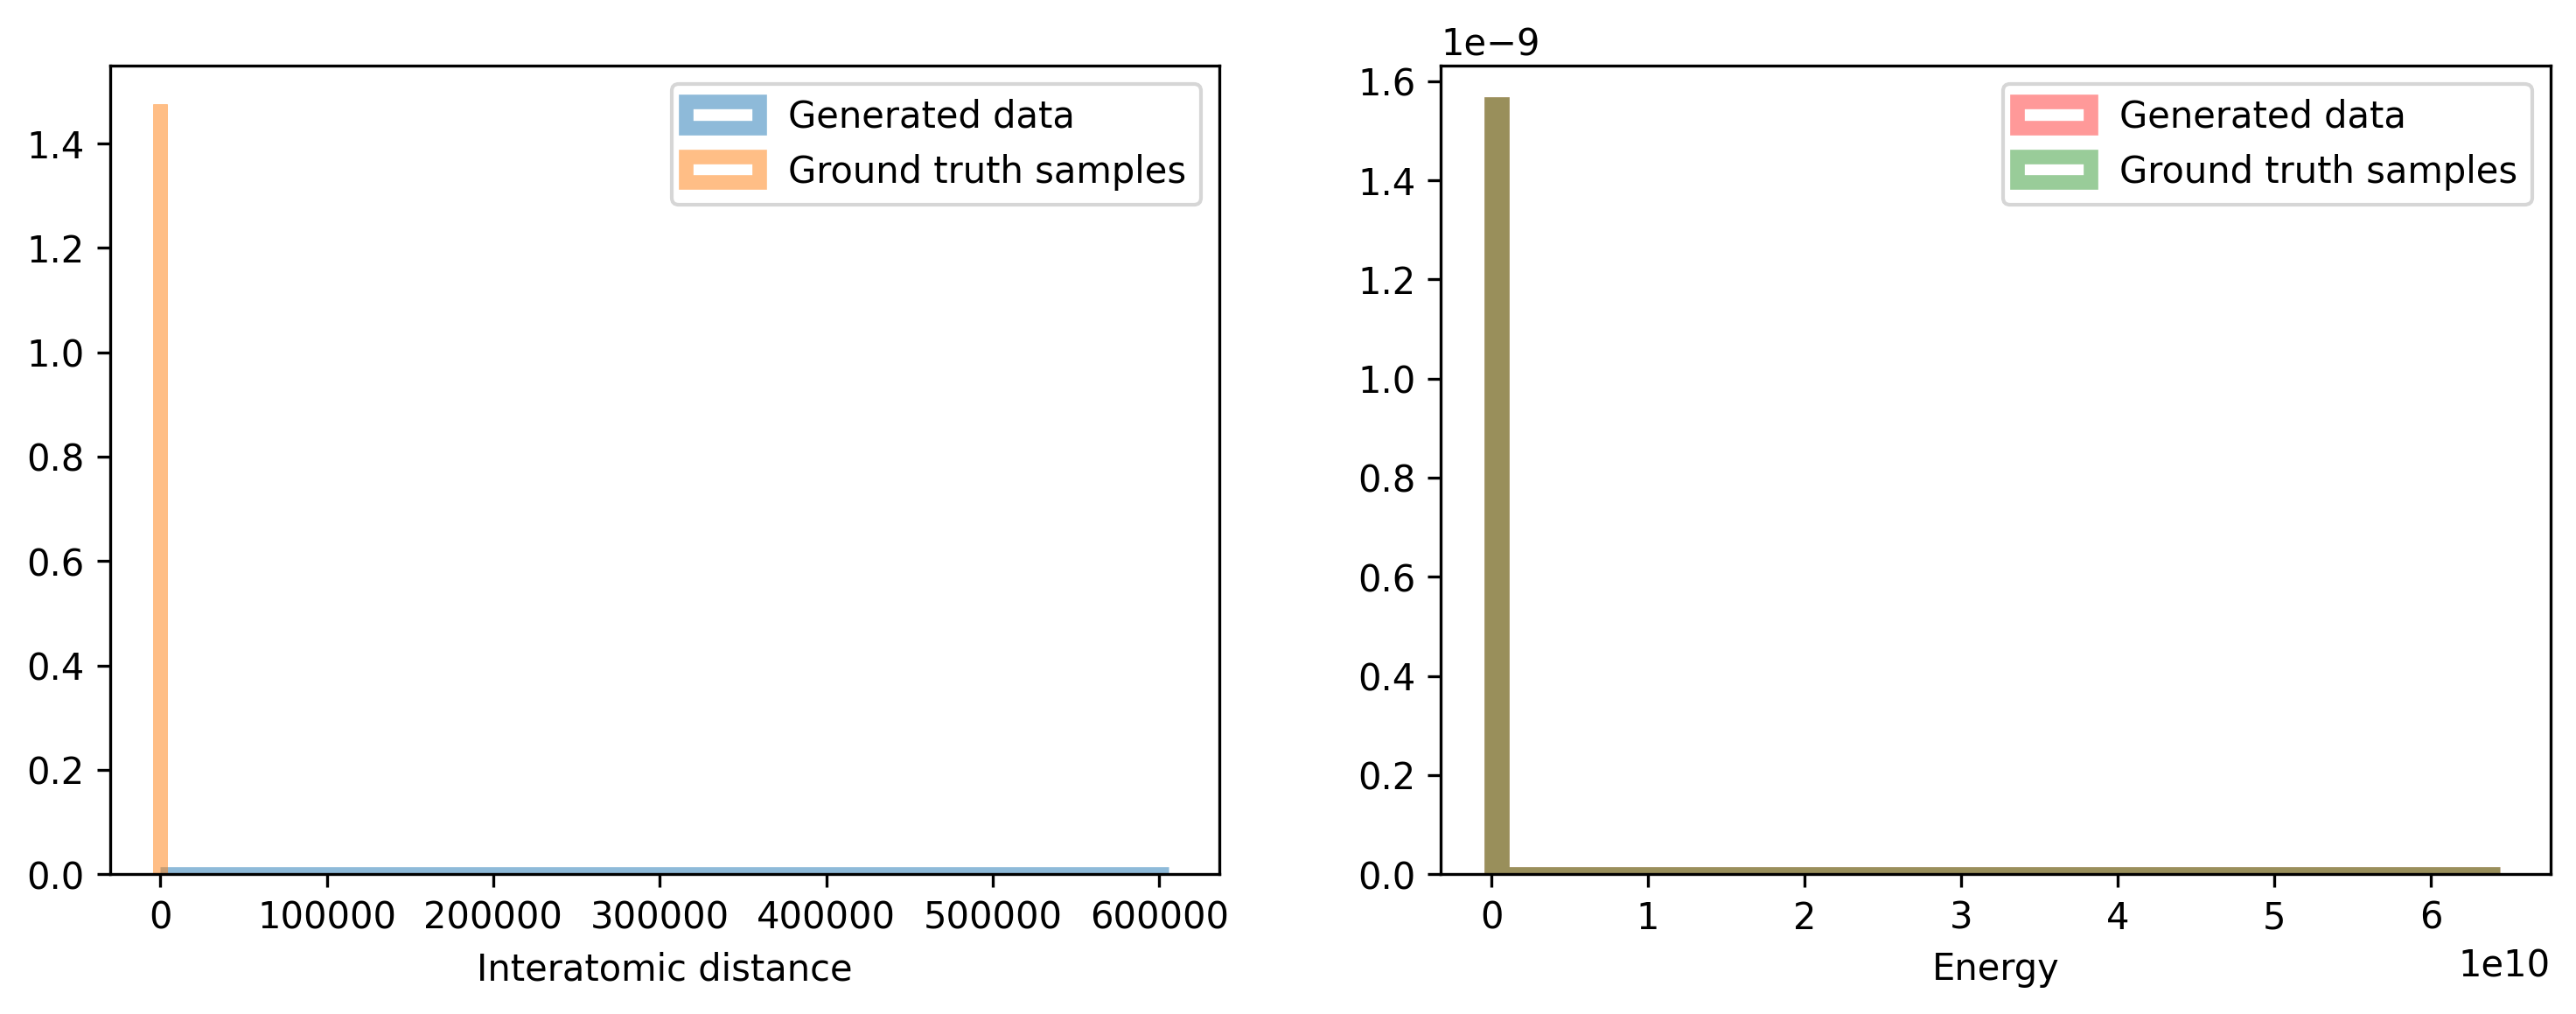

In [10]:
butler.visualise(samples[::10])